In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from aps_ai.beamline34IDC.simulation.facade.focusing_optics_interface import Movement

from aps_ai.beamline34IDC.util.shadow.common import \
    plot_shadow_beam_spatial_distribution, get_shadow_beam_spatial_distribution,\
    load_shadow_beam, PreProcessorFiles, EmptyBeamException
from aps_ai.beamline34IDC.optimization import movers, configs, display_utils, common as opt_common
from aps_ai.beamline34IDC.optimization.scipy_nelder_mead import ScipyOptimizer
from aps_ai.beamline34IDC.optimization.skopt_gp import SkoptGaussianProcessOptimizer, SkoptDiscreteGPOptimizer
import beamline34IDC.optimization.movers as movers

from aps_ai.beamline34IDC.optimization.display_utils import LivePlotCallback
from aps_ai.beamline34IDC.util import clean_up
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm
import shutil
import IPython
from skopt.callbacks import DeltaXStopper, DeltaYStopper, DeadlineStopper
from pathlib import Path
import optuna

In [8]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)
print(DEFAULT_RANDOM_SEED)

79676


In [9]:
base_dir = Path('/gpfs/fs1/home/skandel/code/oasys_ml/ML_Control_System/')
orig_work_dir = base_dir /'work_directory'
temp_work_dir = base_dir / f'tmp_work_dir_{DEFAULT_RANDOM_SEED}'
temp_work_dir.mkdir(exist_ok=True)

In [10]:
dat_files = list(orig_work_dir.glob('*.dat')) + list(orig_work_dir.glob('*.ini'))
for df in dat_files:
    shutil.copy(df, temp_work_dir)

In [11]:
os.chdir(temp_work_dir)

In [12]:
input_beam_path = "primary_optics_system_beam.dat"

In [13]:
move_motors = ['hkb_1', 'vkb_1', 'hkb_2', 'vkb_2', 'hkb_3', 'vkb_3', 'hkb_4', 'vkb_4']

In [14]:
motors_str = move_motors[0] if len(move_motors) == 1 else '_'.join(move_motors)
fig_save_path = f'{orig_work_dir}/figures/{motors_str}/'
if not os.path.isdir(fig_save_path):
    os.mkdir(fig_save_path)

In [20]:
# Focusing Optics System -------------------------
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=True)

In [21]:
initial_absolute_positions = np.array(movers.get_absolute_positions(focusing_system, move_motors))
print(initial_absolute_positions)

[0.2500515 0.1425    0.1570341 0.2995    3.        3.        0.
 0.       ]


In [22]:
move_motors_ranges = {'hkb_1': [-0.03, 0.03], 
                      'vkb_1': [-0.03, 0.03],
                      'hkb_2': [-0.03, 0.03],
                      'vkb_2': [-0.03, 0.03],
                      'hkb_3': [-0.02, 0.02],
                      'vkb_3': [-0.02, 0.02],
                      'hkb_4': [-0.01, 0.01], 
                      'vkb_4': [-0.01, 0.01]}

In [84]:
hkb_motors_ranges = {k:v for k, v in move_motors_ranges.items() if 'hkb' in k}

In [86]:
vkb_motors_ranges = {k:v for k, v in move_motors_ranges.items() if 'vkb' in k}

In [73]:
class OptunaOptimizer(opt_common.OptimizationCommon):
    """"""
    opt_platform = 'optuna'
    
    def loss_function(self, translations: list, verbose: bool = True) -> float:
        """This mutates the state of the focusing system."""

        self.focusing_system = movers.move_motors(self.focusing_system, self.motor_types, translations,
                                                  movement='relative')
        self._update_beam_state()

        loss = [lossfn() for lossfn in self._loss_function_list]

        self._opt_trials_motor_positions.append(translations)
        self._opt_trials_losses.append(loss)
        self._opt_fn_call_counter += 1
        if verbose:
            print("motors", self.motor_types, "trans", translations, "current loss", loss)
        return loss
    
    def objective(self, trial):
        translations = []
        for mt, r in zip(self.motor_types, self.motor_ranges):
            translations.append(trial.suggest_float(mt, r[0], r[1]))
        loss_this = self._lossfn_this(translations)
        return loss_this
    
    def trials(self, n_guesses = 1, verbose: bool = False, accept_all_solutions: bool = False):
        pass
    
    def _optimize(self):
        pass
    def set_optimizer_options(self):
        pass
    
    def get_random_init(self, guess_range = None, verbose=True):
        if guess_range is None:
            guess_range = [np.array(configs.DEFAULT_MOVEMENT_RANGES[mt]) / 2 for mt in self.motor_types]
        elif np.ndim(guess_range) == 1 and len(guess_range) == 2:
            guess_range = [guess_range for mt in self.motor_types]
        elif np.ndim(guess_range) != 2 or len(guess_range) != len(self.motor_types):
            raise ValueError("Invalid range supplied for guesses.")

        initial_guess = [np.random.uniform(m1, m2) for (m1, m2) in guess_range]
        lossfn_obj_this = self.TrialInstanceLossFunction(self, verbose=verbose)
        guess_loss = lossfn_obj_this.loss(initial_guess, verbose=False)
        if verbose:
            print('Random guess', initial_guess, 'has loss', guess_loss)
        
        while np.sum(guess_loss) >= self._no_beam_loss or np.isnan(np.sum(guess_loss)):
            self.reset()
            if verbose:
                print("Random guess", initial_guess, "produces beam out of bounds. Trying another guess.")
            initial_guess = [np.random.uniform(m1, m2) for (m1, m2) in guess_range]
            if verbose:
                print('Random guess is', initial_guess)
            guess_loss = lossfn_obj_this.loss(initial_guess, verbose=False)
        return initial_guess
    
    

In [197]:
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path)

In [198]:
opt_trial = OptunaOptimizer(focusing_system, 
                                              motor_types=move_motors, 
                                              random_seed=DEFAULT_RANDOM_SEED, 
                                              loss_parameters=['centroid', 'sigma'],
                                              loss_min_value=5e-4,
                                              use_gaussian_fit=False)

In [199]:
init_range = np.array(list(move_motors_ranges.values()))

In [200]:
absolute_movements = []

Random guess [0.021434985879278785, 0.016361082703469088, 0.029098000381100636, -0.002469982105962342, -0.0051671529050232225, 0.000743765833824947, 0.005053276641694542, 0.005059115532261373] has loss [0.006273415261557101, 0.00460706347982724]


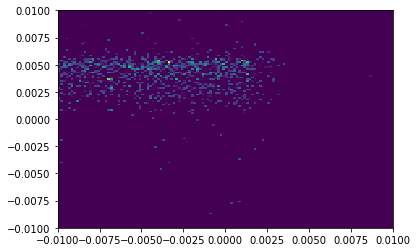

In [201]:
random_inits = opt_trial.get_random_init(guess_range=init_range)
    


absolute_movements.append(initial_absolute_positions + random_inits)

beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system=focusing_system, random_seed=DEFAULT_RANDOM_SEED, xrange=[-0.01, 0.01], yrange=[-0.01, 0.01], nbins=128)
plt.pcolormesh(hist.hh, hist.vv, hist.data_2D)
plt.show()

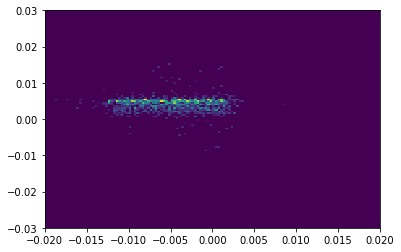

In [202]:
beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system=focusing_system, random_seed=DEFAULT_RANDOM_SEED, xrange=[-0.02, 0.02], yrange=[-0.03, 0.03], nbins=128)
plt.pcolormesh(hist.hh, hist.vv, hist.data_2D)
plt.show()

In [203]:
focusing_system = opt_trial.focusing_system

In [204]:
opt_trial1 = OptunaOptimizer(focusing_system, 
                             motor_types=list(hkb_motors_ranges.keys())[2:], 
                             random_seed=DEFAULT_RANDOM_SEED, 
                             loss_parameters=['centroid'],
                             loss_min_value=5e-4,
                             use_gaussian_fit=False)
opt_trial1.motor_ranges = np.array(list(hkb_motors_ranges.values())[2:])
opt_trial1._lossfn_obj_this = opt_trial1.TrialInstanceLossFunction(opt_trial1, verbose=False)
opt_trial1._lossfn_this = opt_trial1._lossfn_obj_this.loss

In [205]:
study = optuna.create_study(directions=['minimize'])

[I 2022-09-10 16:46:45,936] A new study created in memory with name: no-name-bea96d35-6651-422f-8a28-4c1172710f86


In [206]:
study.optimize(opt_trial1.objective, n_trials=50)
#study.optimize(opt_trial2.objective, n_trials=10)

[I 2022-09-10 16:46:54,375] Trial 0 finished with value: 0.00485788905414218 and parameters: {'hkb_3': 0.003043973170425051, 'hkb_4': -0.0017008680189569622}. Best is trial 0 with value: 0.00485788905414218.
[I 2022-09-10 16:46:58,734] Trial 1 finished with value: 0.004098574066411444 and parameters: {'hkb_3': 0.018303477424057888, 'hkb_4': -0.00013229396056066087}. Best is trial 1 with value: 0.004098574066411444.
[I 2022-09-10 16:47:03,449] Trial 2 finished with value: 0.006907360177349502 and parameters: {'hkb_3': -0.00877724688941659, 'hkb_4': -0.0016605004800811767}. Best is trial 1 with value: 0.004098574066411444.
[I 2022-09-10 16:47:08,042] Trial 3 finished with value: 0.004250293085800738 and parameters: {'hkb_3': 0.006360928019045541, 'hkb_4': -0.002237883225582953}. Best is trial 1 with value: 0.004098574066411444.
[I 2022-09-10 16:47:12,618] Trial 4 finished with value: 0.004112017655263524 and parameters: {'hkb_3': 0.010358227526380683, 'hkb_4': -0.0033576672914265027}. Be

In [207]:
trials = study.best_trials

In [208]:
trials

[FrozenTrial(number=1, values=[0.004098574066411444], datetime_start=datetime.datetime(2022, 9, 10, 16, 46, 54, 377647), datetime_complete=datetime.datetime(2022, 9, 10, 16, 46, 58, 734189), params={'hkb_3': 0.018303477424057888, 'hkb_4': -0.00013229396056066087}, distributions={'hkb_3': UniformDistribution(high=0.02, low=-0.02), 'hkb_4': UniformDistribution(high=0.01, low=-0.01)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=1, state=TrialState.COMPLETE, value=None)]

In [142]:
xvals = []
yvals = []
idxs = []
params = []
for t in trials:
    xvals.append(t.values[0])
    yvals.append(t.values[1])
    idxs.append(t.number)
    params.append(t.params.values())
    

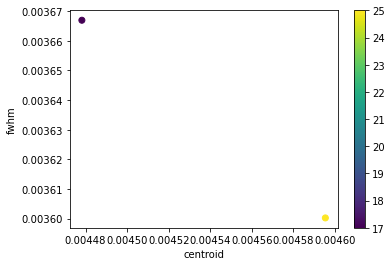

In [143]:
plt.scatter(xvals, yvals, c=idxs)
plt.xlabel('centroid')
plt.ylabel('fwhm')
plt.colorbar()

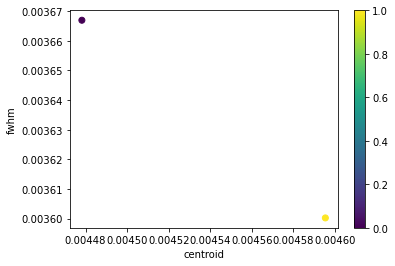

In [144]:
plt.scatter(xvals, yvals, c=np.arange(len(xvals)))
plt.xlabel('centroid')
plt.ylabel('fwhm')
plt.colorbar()

dict_values([0.007753201881758542, 0.01599870183342051, -0.007100292126874085, 0.0016346948157988997])


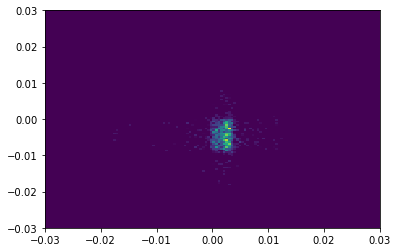

dict_values([0.02599725498457267, 0.002618331686709406, 0.0030446104823436335, 0.005517552335661995])


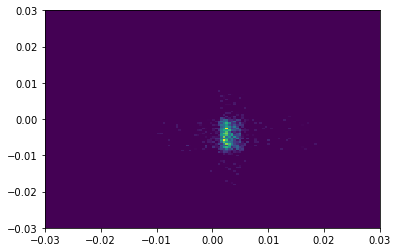

In [145]:
for pars in params:
    opt_trial1._lossfn_this(np.array(list(pars)))
    beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system=focusing_system, random_seed=DEFAULT_RANDOM_SEED, xrange=[-0.03, 0.03], yrange=[-0.03, 0.03], nbins=128)
    print(pars)
    plt.pcolormesh(hist.hh, hist.vv, hist.data_2D)
    plt.show()

In [146]:
opt_trial1._lossfn_this(np.array(list(params[0])))

[0.004910968075958509, 0.003699596879323574]

In [147]:
opt_trial2 = OptunaOptimizer(focusing_system, 
                             motor_types=list(vkb_motors_ranges.keys()), 
                             random_seed=DEFAULT_RANDOM_SEED, 
                             loss_parameters=['centroid', 'sigma'],
                             loss_min_value=5e-4,
                             use_gaussian_fit=False)
opt_trial2.motor_ranges = np.array(list(vkb_motors_ranges.values()))
opt_trial2._lossfn_obj_this = opt_trial2.TrialInstanceLossFunction(opt_trial2, verbose=False)
opt_trial2._lossfn_this = opt_trial2._lossfn_obj_this.loss

In [148]:
study = optuna.create_study(directions=['minimize', 'minimize'])

[I 2022-09-10 16:26:59,635] A new study created in memory with name: no-name-19fa8990-a002-4b6f-a53c-80f02e349ff8


In [149]:
study.optimize(opt_trial2.objective, n_trials=50)
#study.optimize(opt_trial2.objective, n_trials=10)

[I 2022-09-10 16:27:06,411] Trial 0 finished with values: [0.01017465742964017, 0.005124627521898723] and parameters: {'vkb_1': 0.026140187344013043, 'vkb_2': 0.005361257178602398, 'vkb_3': 0.019150007085297596, 'vkb_4': 0.004292584716299223}. 
[I 2022-09-10 16:27:08,747] Trial 1 finished with values: [0.019942558663392177, 0.004746089219607632] and parameters: {'vkb_1': -0.0026275816161017637, 'vkb_2': 0.0010392821458932201, 'vkb_3': 0.01734884485983253, 'vkb_4': -0.009085415391803728}. 
[I 2022-09-10 16:27:11,004] Trial 2 finished with values: [0.01086148735691517, 0.002982623175695592] and parameters: {'vkb_1': -0.023026795294989005, 'vkb_2': -0.007979819299511654, 'vkb_3': 0.0037840381758191682, 'vkb_4': -0.005328707481490904}. 
[I 2022-09-10 16:27:13,251] Trial 3 finished with values: [0.0025153895465234353, 0.0036048979054867903] and parameters: {'vkb_1': 0.01094928171453146, 'vkb_2': -0.014047506463435794, 'vkb_3': 0.0003826695853460377, 'vkb_4': 0.007704229657310357}. 
[I 2022-

In [150]:
trials = study.best_trials

In [151]:
trials

[FrozenTrial(number=2, values=[0.01086148735691517, 0.002982623175695592], datetime_start=datetime.datetime(2022, 9, 10, 16, 27, 8, 748135), datetime_complete=datetime.datetime(2022, 9, 10, 16, 27, 11, 4370), params={'vkb_1': -0.023026795294989005, 'vkb_2': -0.007979819299511654, 'vkb_3': 0.0037840381758191682, 'vkb_4': -0.005328707481490904}, distributions={'vkb_1': UniformDistribution(high=0.03, low=-0.03), 'vkb_2': UniformDistribution(high=0.03, low=-0.03), 'vkb_3': UniformDistribution(high=0.02, low=-0.02), 'vkb_4': UniformDistribution(high=0.01, low=-0.01)}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, trial_id=2, state=TrialState.COMPLETE, value=None),
 FrozenTrial(number=3, values=[0.0025153895465234353, 0.0036048979054867903], datetime_start=datetime.datetime(2022, 9, 10, 16, 27, 11, 5247), datetime_complete=datetime.datetime(2022, 9, 10, 16, 27, 13, 250933), params={'vkb_1': 0.01094928171453146, 'vkb_2': -0.014047506463435794, 'vkb_3': 0.0003826

In [152]:
xvals = []
yvals = []
idxs = []
params = []
for t in trials:
    xvals.append(t.values[0])
    yvals.append(t.values[1])
    idxs.append(t.number)
    params.append(t.params.values())
    

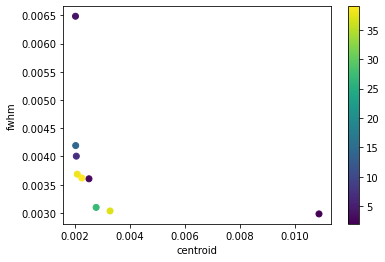

In [153]:
plt.scatter(xvals, yvals, c=idxs)
plt.xlabel('centroid')
plt.ylabel('fwhm')
plt.colorbar()

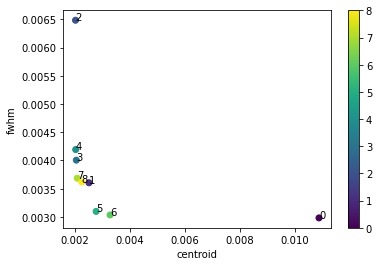

In [158]:
plt.scatter(xvals, yvals, c=np.arange(len(xvals)))
for i in range(len(xvals)):
    plt.annotate(str(i), (xvals[i], yvals[i]))
plt.xlabel('centroid')
plt.ylabel('fwhm')
plt.colorbar()

dict_values([-0.023026795294989005, -0.007979819299511654, 0.0037840381758191682, -0.005328707481490904])


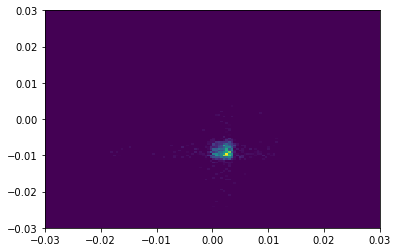

dict_values([0.01094928171453146, -0.014047506463435794, 0.0003826695853460377, 0.007704229657310357])


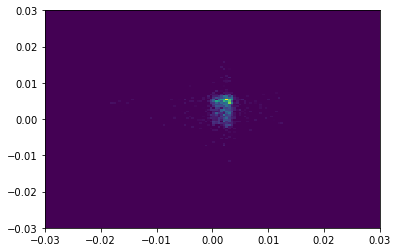

dict_values([-0.007077951280115978, -0.000504362156872603, -0.01723436841359705, -0.0039048642465601534])


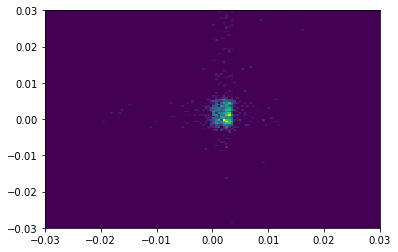

dict_values([-0.011067444529912453, 0.016380890408058867, 0.0004138962611424449, 0.003670693862989672])


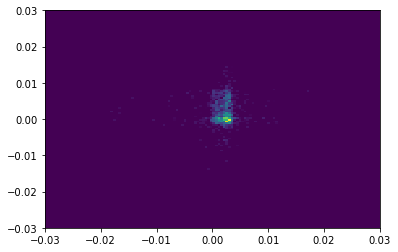

dict_values([-0.013543166546381859, 0.02410090428343438, 0.005679286960128805, 0.004816735691399962])


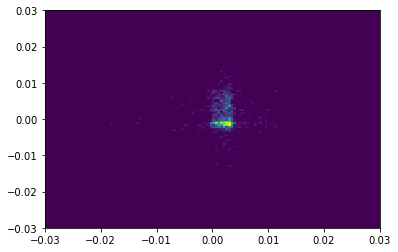

dict_values([-0.018351665131631976, -0.0061397545450877465, -0.004335821994163037, 0.003383309676890706])


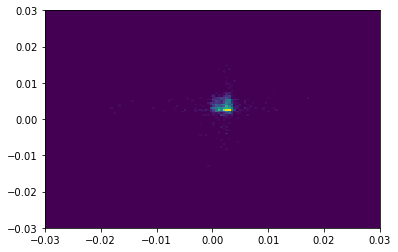

dict_values([-0.006107924564332769, -0.015003565862863166, 0.008062569323242796, 0.005071595585675603])


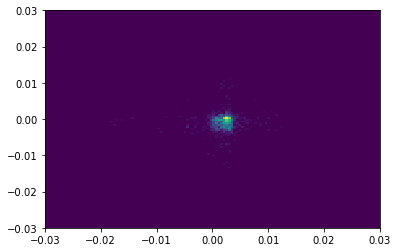

dict_values([-0.02771575421485901, 0.016864160713565328, 0.0033219884736915006, 0.001623201901967554])


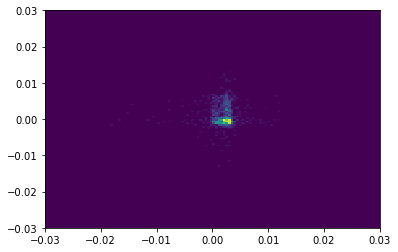

dict_values([0.011048792143387415, -0.012055037060789715, -0.005860600323024165, 0.0030527040539086413])


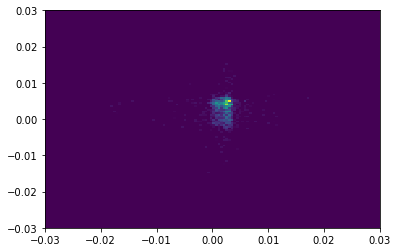

In [155]:
for pars in params:
    opt_trial2._lossfn_this(np.array(list(pars)))
    beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system=focusing_system, random_seed=DEFAULT_RANDOM_SEED, xrange=[-0.03, 0.03], yrange=[-0.03, 0.03], nbins=128)
    print(pars)
    plt.pcolormesh(hist.hh, hist.vv, hist.data_2D)
    plt.show()

In [159]:
opt_trial2._lossfn_this(np.array(list(params[5])))

[0.0040056104157546795, 0.003097778042143124]

In [160]:
opt_trial1 = OptunaOptimizer(focusing_system, 
                             motor_types=list(vkb_motors_ranges.keys()), 
                             random_seed=DEFAULT_RANDOM_SEED, 
                             loss_parameters=['centroid', 'sigma'],
                             loss_min_value=5e-4,
                             use_gaussian_fit=False)
opt_trial1.motor_ranges = np.array(list(vkb_motors_ranges.values()))
opt_trial1._lossfn_obj_this = opt_trial1.TrialInstanceLossFunction(opt_trial1, verbose=False)
opt_trial1._lossfn_this = opt_trial1._lossfn_obj_this.loss

In [161]:
study = optuna.create_study(directions=['minimize', 'minimize'])

[I 2022-09-10 16:34:56,228] A new study created in memory with name: no-name-70f23f62-b6f4-4c47-8549-a0c5e520033f


In [162]:
study.optimize(opt_trial1.objective, n_trials=50)
#study.optimize(opt_trial2.objective, n_trials=10)

[I 2022-09-10 16:35:01,679] Trial 0 finished with values: [0.002217870377136082, 0.0032981552803421623] and parameters: {'vkb_1': -0.024210195572404627, 'vkb_2': 0.015152214829706391, 'vkb_3': 0.005645484621192947, 'vkb_4': -0.0022193565040555495}. 
[I 2022-09-10 16:35:04,732] Trial 1 finished with values: [0.01738083524920225, 0.00479403460577113] and parameters: {'vkb_1': 0.02883956862024331, 'vkb_2': 0.02809677505309309, 'vkb_3': -0.014596114723228935, 'vkb_4': 0.00771167242505834}. 
[I 2022-09-10 16:35:07,787] Trial 2 finished with values: [0.017659300450181114, 0.003726990788232283] and parameters: {'vkb_1': 0.012158729256602094, 'vkb_2': 0.011104542329469079, 'vkb_3': -0.017860100886178402, 'vkb_4': 0.005409494485036812}. 
[I 2022-09-10 16:35:10,730] Trial 3 finished with values: [0.020241145915602467, 0.0035449819967137493] and parameters: {'vkb_1': 0.011115795025917953, 'vkb_2': -0.002322090807339805, 'vkb_3': -0.01605288171502382, 'vkb_4': 0.009180036804974584}. 
[I 2022-09-10

In [163]:
trials = study.best_trials

In [164]:
trials

[FrozenTrial(number=5, values=[0.003660648631527195, 0.0029237269331440934], datetime_start=datetime.datetime(2022, 9, 10, 16, 35, 13, 524677), datetime_complete=datetime.datetime(2022, 9, 10, 16, 35, 15, 785343), params={'vkb_1': -0.0005243003107627472, 'vkb_2': -0.005574122922444261, 'vkb_3': 0.013221518995996311, 'vkb_4': -0.0018174589560403624}, distributions={'vkb_1': UniformDistribution(high=0.03, low=-0.03), 'vkb_2': UniformDistribution(high=0.03, low=-0.03), 'vkb_3': UniformDistribution(high=0.02, low=-0.02), 'vkb_4': UniformDistribution(high=0.01, low=-0.01)}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, trial_id=5, state=TrialState.COMPLETE, value=None),
 FrozenTrial(number=13, values=[0.0021751015783030916, 0.0030632710230948006], datetime_start=datetime.datetime(2022, 9, 10, 16, 35, 32, 680245), datetime_complete=datetime.datetime(2022, 9, 10, 16, 35, 35, 54011), params={'vkb_1': 0.004081688285810646, 'vkb_2': -0.02284282677965071, 'vkb_3': -

In [165]:
xvals = []
yvals = []
idxs = []
params = []
for t in trials:
    xvals.append(t.values[0])
    yvals.append(t.values[1])
    idxs.append(t.number)
    params.append(t.params.values())
    

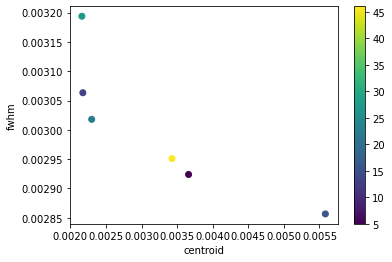

In [166]:
plt.scatter(xvals, yvals, c=idxs)
plt.xlabel('centroid')
plt.ylabel('fwhm')
plt.colorbar()

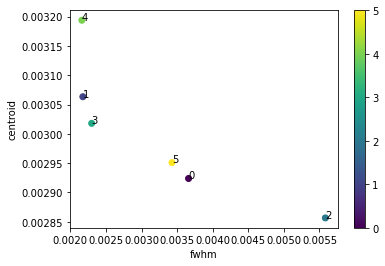

In [170]:
plt.scatter(xvals, yvals, c=np.arange(len(xvals)))
for i in range(len(xvals)):
    plt.annotate(str(i), (xvals[i], yvals[i]))
plt.xlabel('fwhm')
plt.ylabel('centroid')
plt.colorbar()

dict_values([-0.0005243003107627472, -0.005574122922444261, 0.013221518995996311, -0.0018174589560403624])


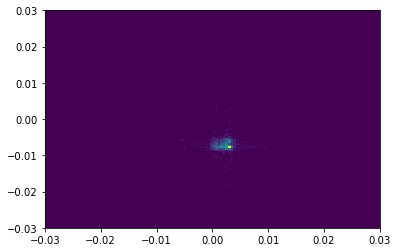

dict_values([0.004081688285810646, -0.02284282677965071, -0.0005572585922730966, -0.0036130958411006667])


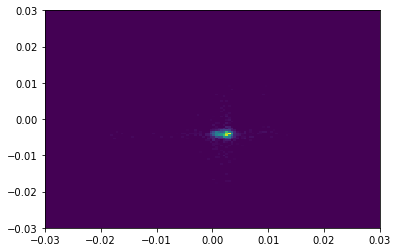

dict_values([0.003922744911349474, -0.02928483415986929, 0.009901742029053574, 0.006302790777368667])


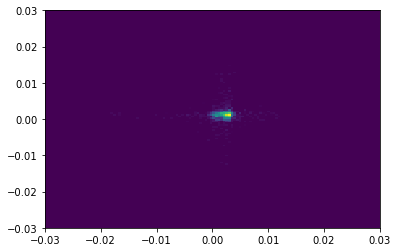

dict_values([-0.02087222376564675, -0.007962548761009717, 0.014220812340253876, -0.0004095105776632281])


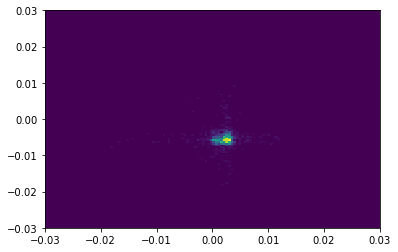

dict_values([-0.020024762040387997, -0.02424887703260218, 0.013633447293129573, -4.645610421173847e-05])


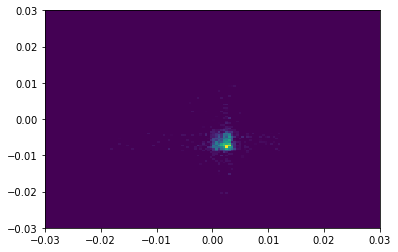

dict_values([0.0034871181528263046, -0.014744170863010327, 0.015570507452412386, 0.0023750842114649267])


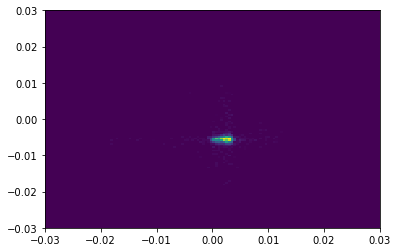

In [168]:
for pars in params:
    opt_trial1._lossfn_this(np.array(list(pars)))
    beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system=focusing_system, random_seed=DEFAULT_RANDOM_SEED, xrange=[-0.03, 0.03], yrange=[-0.03, 0.03], nbins=128)
    print(pars)
    plt.pcolormesh(hist.hh, hist.vv, hist.data_2D)
    plt.show()

In [171]:
opt_trial1._lossfn_this(np.array(list(params[2])))

[0.002006740863803456, 0.00292173576549461]

In [172]:
opt_trial2 = OptunaOptimizer(focusing_system, 
                             motor_types=list(vkb_motors_ranges.keys()), 
                             random_seed=DEFAULT_RANDOM_SEED, 
                             loss_parameters=['centroid', 'sigma'],
                             loss_min_value=5e-4,
                             use_gaussian_fit=False)
opt_trial2.motor_ranges = np.array(list(vkb_motors_ranges.values()))
opt_trial2._lossfn_obj_this = opt_trial2.TrialInstanceLossFunction(opt_trial2, verbose=False)
opt_trial2._lossfn_this = opt_trial2._lossfn_obj_this.loss

In [173]:
study = optuna.create_study(directions=['minimize', 'minimize'])

[I 2022-09-10 16:39:34,325] A new study created in memory with name: no-name-a429082a-58fc-4fc0-b07b-69934e892cdc


In [174]:
study.optimize(opt_trial2.objective, n_trials=50)
#study.optimize(opt_trial2.objective, n_trials=10)

[I 2022-09-10 16:39:36,562] Trial 0 finished with values: [0.0020465901335605446, 0.003554471711068791] and parameters: {'vkb_1': -0.003606890869645416, 'vkb_2': -0.020445140785588806, 'vkb_3': -0.009840479792546599, 'vkb_4': -0.0043709483366646705}. 
[I 2022-09-10 16:39:38,807] Trial 1 finished with values: [0.01122058347385648, 0.004646366344384246] and parameters: {'vkb_1': 0.02921585969366413, 'vkb_2': 0.02831015052809774, 'vkb_3': -0.008109518073905916, 'vkb_4': 0.008265009393026447}. 
[I 2022-09-10 16:39:41,011] Trial 2 finished with values: [0.010295114026681231, 0.0030917729354450235] and parameters: {'vkb_1': 0.008365315444996031, 'vkb_2': -0.022787963784359027, 'vkb_3': -0.0060724241112613386, 'vkb_4': 0.007038389448269991}. 
[I 2022-09-10 16:39:43,222] Trial 3 finished with values: [0.0038500289482749145, 0.003012893253343143] and parameters: {'vkb_1': -0.0012752233824199141, 'vkb_2': 0.02975966173481477, 'vkb_3': 0.0001375455604189224, 'vkb_4': 0.0007665807845642011}. 
[I 2

In [175]:
trials = study.best_trials

In [176]:
trials

[FrozenTrial(number=7, values=[0.01103938945301552, 0.002868525329247299], datetime_start=datetime.datetime(2022, 9, 10, 16, 39, 50, 213003), datetime_complete=datetime.datetime(2022, 9, 10, 16, 39, 52, 425494), params={'vkb_1': -0.010216575896916914, 'vkb_2': 0.023222976456757374, 'vkb_3': -0.005526257464719521, 'vkb_4': 0.005576438631317744}, distributions={'vkb_1': UniformDistribution(high=0.03, low=-0.03), 'vkb_2': UniformDistribution(high=0.03, low=-0.03), 'vkb_3': UniformDistribution(high=0.02, low=-0.02), 'vkb_4': UniformDistribution(high=0.01, low=-0.01)}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, trial_id=7, state=TrialState.COMPLETE, value=None),
 FrozenTrial(number=24, values=[0.0019778451216804506, 0.002931886667586945], datetime_start=datetime.datetime(2022, 9, 10, 16, 40, 32, 348032), datetime_complete=datetime.datetime(2022, 9, 10, 16, 40, 34, 626343), params={'vkb_1': -0.013453010028365193, 'vkb_2': 0.023345035597937776, 'vkb_3': -0.00

In [177]:
xvals = []
yvals = []
idxs = []
params = []
for t in trials:
    xvals.append(t.values[0])
    yvals.append(t.values[1])
    idxs.append(t.number)
    params.append(t.params.values())
    

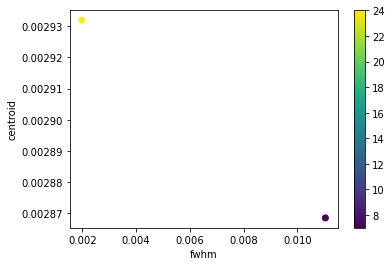

In [181]:
plt.scatter(xvals, yvals, c=idxs)
plt.xlabel('fwhm')
plt.ylabel('centroid')
plt.colorbar()

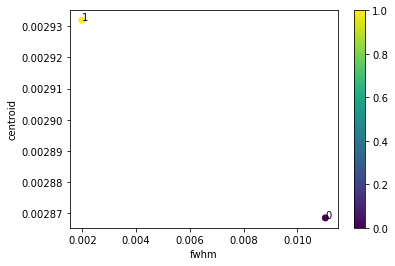

In [182]:
plt.scatter(xvals, yvals, c=np.arange(len(xvals)))
for i in range(len(xvals)):
    plt.annotate(str(i), (xvals[i], yvals[i]))
plt.xlabel('fwhm')
plt.ylabel('centroid')
plt.colorbar()

dict_values([-0.010216575896916914, 0.023222976456757374, -0.005526257464719521, 0.005576438631317744])


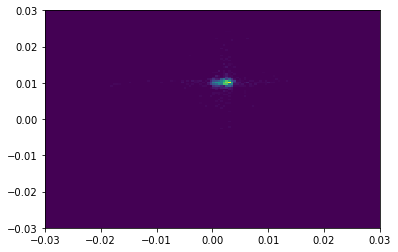

dict_values([-0.013453010028365193, 0.023345035597937776, -0.0009636450980520725, -0.002530817340571598])


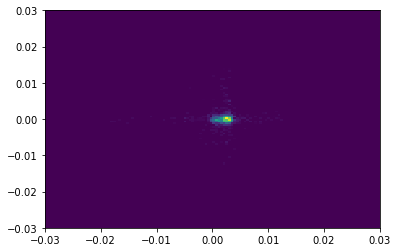

In [183]:
for pars in params:
    opt_trial2._lossfn_this(np.array(list(pars)))
    beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system=focusing_system, random_seed=DEFAULT_RANDOM_SEED, xrange=[-0.03, 0.03], yrange=[-0.03, 0.03], nbins=128)
    print(pars)
    plt.pcolormesh(hist.hh, hist.vv, hist.data_2D)
    plt.show()